In [1]:
# importing packages to be used in the notebook
import numpy as np
import numba
from numba import njit
import warnings
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator

warnings.simplefilter('always', RuntimeWarning)

# plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
# plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'font.size': 15})
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 15}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#006BA2','#DB444B','#000000','#EBB434',
                                                    '#3EBCD2','#379A8B','#9A607F', '#B4BA39', '#754C24']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from sequence_jacobian import drawdag
from sequence_jacobian import JacobianDict
from scipy.interpolate import interp1d
from types import SimpleNamespace

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

In [2]:
T = 300
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

cali_main = {'gamma': 0.8, 'qh': 8.0, 'sigma': 2.0, 'alpha': 0.1, 'bmax': 45, 'rhom': 0.9,
            'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
            'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
            'kappa': 0.1, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

unknowns_ss = {'beta': 0.983, 'varphi': 0.833, 'theta': 0.05}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

devss = ['Y', 'qh', 'C_BHAT', 'w', 'N', 'Div', 'Tax', 'CHI']

# 1. Nominal Assets

In [3]:
hh = hh_housing_v3.hh_housecons_sep
hh_name = hh.name
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

blocks_ss_nom = [hh1, utils.firm, utils.taylor, utils.real_rate_nom, utils.fiscal, utils.wage_res_sep, 
                utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]

blocks_ss_real = [hh1, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
                utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]

blocks_nom = [hh1, utils.firm, utils.taylor, utils.real_rate_nom, utils.fiscal, utils.wage_res_sep, 
                utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

blocks_real = [hh1, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
                utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

hank_ss_nom = create_model(blocks_ss_nom, name="Nominal Assets SS")
hank_ss_real = create_model(blocks_ss_real, name="Real Assets SS")

hank_nom = create_model(blocks_nom, name="Nominal Assets")
hank_real = create_model(blocks_real, name="Real Assets")

ss = {}
irf = {}
models = {'nom_assets': hank_nom, 'real_assets': hank_real}

In [4]:
ss0 = hank_ss_nom.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
ss['nom_assets'] = models['nom_assets'].steady_state(ss0)

ss0 = hank_ss_real.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
ss['real_assets'] = models['real_assets'].steady_state(ss0)

In [5]:
sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

irf_nom = models['nom_assets'].solve_impulse_linear(ss['nom_assets'], unknowns, targets, {"epsm": dr}, verbose = False)
irf_real = models['real_assets'].solve_impulse_linear(ss['real_assets'], unknowns, targets, {"epsm": dr}, verbose = False)

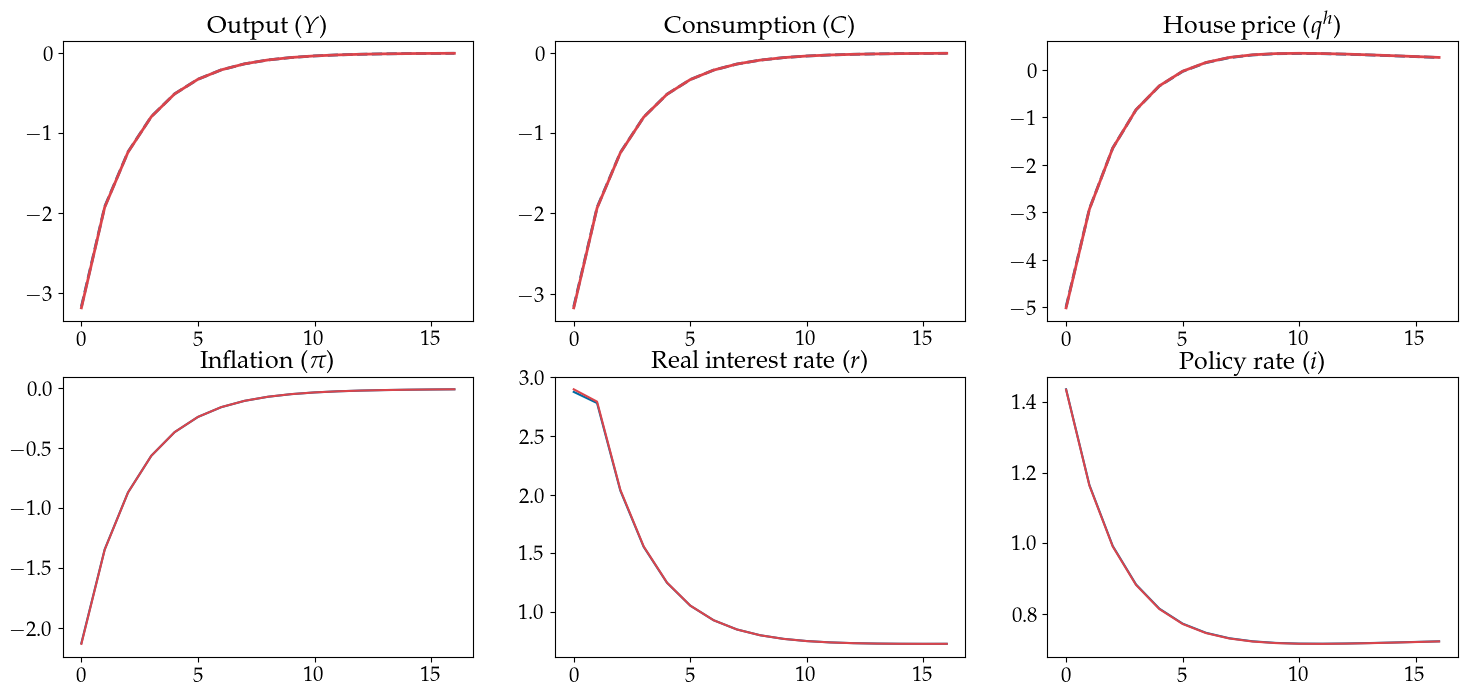

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(18,12*2/3))
ax = ax.flatten()

H = 17
var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'qh': r'House price ($q^h$)',
            'pi': r'Inflation ($\pi$)', 'r': r'Real interest rate ($r$)', 'i': r'Policy rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    # ax[i].plot(100*ifr_main[key][:21])
    if key in devss: 
        ax[i].plot(100*(irf_nom[key][:H]/ss['nom_assets'][key]), linewidth=2, label = 'Model', ls = '--')
        ax[i].plot(100*(irf_real[key][:H]/ss['real_assets'][key]), linewidth=2, color = '#DB444B', label = 'Model')
    else:
        ax[i].plot(100*(irf_nom[key][:H] + ss['nom_assets'][key]))
        ax[i].plot(100*(irf_real[key][:H] + ss['real_assets'][key]))
    ax[i].set_title(var_name[key])

# 2. Investment

In [7]:
# Import standard packages

import numpy as np  
import matplotlib.pyplot as plt 
import sequence_jacobian as sj  

In [8]:
calibration = {'eis': 0.5,     # EIS
               'rho_e': 0.92,  # Persistence of idiosyncratic productivity shocks
               'sd_e': 0.92,   # Standard deviation of idiosyncratic productivity shocks
               'Y': 1.,        # Output
               'r_ante': 0.01, # target real interest rate
               'min_a': -1,    # Minimum asset level on the grid
               'max_a': 1_000, # Maximum asset level on the grid
               'n_a': 500,     # Number of asset grid points
               'n_e': 11,      # Number of productivity grid points
               'psi': 1.0,
               'delta': 0.05}

In [9]:
hh = sj.hetblocks.hh_sim.hh
make_grids = sj.hetblocks.hh_sim.make_grids

In [10]:
def income(Y, e_grid):
    # post-tax labor income
    y = Y * e_grid
    return y

household_simple = hh.add_hetinputs([make_grids, income])

In [11]:
@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r

@sj.simple
def mkt_clearing_simple(A, Y, C):
    asset_mkt = A
    goods_mkt = C - Y
    return asset_mkt, goods_mkt

ha_simple = sj.create_model([household_simple, ex_post_rate, mkt_clearing_simple])

In [ ]:
# New variables: w, rk, D, I, Q, K
@simple
def firm(X, alpha, K, N):
    Y = X*K**alpha*N**(1-alpha)
    w = X(1-alpha)*K**alpha*N**(-alpha)
    rk = X*alpha*K**(alpha-1)*N**(1-alpha)
    return w, rk, Y

@simple
def capital_firm(psi, p, delta, K):
    Q = p / K(+1)
    I = (1 / psi * (Q - 1) + delta)*K
    return I, Q

@simple
def div(rk, K, I, psi):
    D = rk*K - I - psi/2 * ((K(+1) - K)/K)**2 * K
    return D

@simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r

@simple
def investment():
    inv = 1 / psi * (Q - 1) + delta - I/K
    val = 1 / (1 + r) * (rk(+1) - I(+1) / K(+1) - psi/2 *(I(+1)/K(+1) - delta)**2 + K(+2)/K(+1)*Q(+1)) - Q
    return inv, val 

@simple
def mkt_clearing(A, Y, C, I):
    asset_mkt = A
    goods_mkt = I + C - Y
    return asset_mkt, goods_mkt

ha_capital = sj.create_model([household_simple, firm, capital_firm, div, ex_post_rate, mkt_clearing])

In [15]:
print(ha_capital.inputs)
print(ha_capital.outputs)

['beta', 'eis', 'rho_e', 'sd_e', 'n_e', 'min_a', 'max_a', 'n_a', 'X', 'alpha', 'K', 'N', 'psi', 'p', 'delta', 'r_ante']
['A', 'C', 'w', 'rk', 'Y', 'I', 'Q', 'D', 'r', 'asset_mkt', 'goods_mkt']


# 3. HANK with Capital a lá Auclert et al. (2020) appendix A

In [ ]:
@simple
def nkpc():
    # Wage Phillips curve
    pass

@simple
def capital_firm(r, rk, I, K, Q, psi, delta):
    inv = 1 / psi * (Q - 1) + delta - I/K
    val = 1 / (1 + r) * (rk(+1) - I(+1) / K(+1) - psi/2 *(I(+1)/K(+1) - delta)**2 + K(+2)/K(+1)*Q(+1)) - Q
    return inv, val

@simple
def arbitrage(div, p, r):
    equity = div(+1) + p(+1) - p * (1 + r)
    return equity

@simple
def dividend(K, rK, delta, psi):
    I = K(+1) - (1 - delta) * K
    div = rK*K - I - psi/2 * ((K(+1) - K)/K)**2 * K
    return div

@simple
def production_firm(Y, K, Theta, alpha):
    # Y = Theta * K ** alpha * N ** (1 - alpha)
    N = (Y / (Theta * K ** alpha)) ** (1 / (1 - alpha))
    w = Theta * (1 - alpha) * K ** alpha * N ** (-alpha)
    rk = Theta * alpha * K ** (alpha - 1) * N ** (1 - alpha)
    return Y, w, rk

@simple
def fin_intermediary():
    liquidation = (p + div) - (1 + r(-1))*L(-1)
    return liquidation

@simple
def market_clearing(C, I, K, Y, L, p, psi):
    goods_mkt = C + I + psi/2 * ((K(+1) - K)/K)**2 * K - Y
    asset_mkt = L - p
    return goods_mkt, asset_mkt

@simple
def monetary_policy(rstar, epsm):
    r = rstar + epsm
    return r

production = combine([production_firm, capital_firm])                  # create combined block
production_solved = production.solved(unknowns={'Q': 1., 'K': 10.},    # turn it into solved block
                                      targets=['inv', 'val'],
                                      solver='broyden_custom')

In [ ]:
import sequence_jacobian.hetblocks.hh_sim as hh_sim

def make_grids(rho_e, sd_e, n_e, min_a, max_a, n_a):
    e_grid, _, Pi = grids.markov_rouwenhorst(rho_e, sd_e, n_e)
    a_grid = grids.asset_grid(min_a, max_a, n_a)
    return e_grid, Pi, a_grid


def income(w, e_grid):
    y = w * e_grid
    return y

hh_extended = hh_sim.add_hetinputs([income, make_grids])